光储充园区定容构建（并网）

交流充电桩（慢充）数量为(辆):14，充电功率为(kW)：7
交流侧充电桩下限修改为(kW):84
交流侧充电桩上限修改为(kW):140
xl_user:[ 900  900 1500 1500   84  100]
xu_user:[1200 1200 4000 4000  140  400]
光照数据长度: 24
光照数据（归一化后）:
第0小时: 0.000000
第1小时: 0.000000
第2小时: 0.000000
第3小时: 0.000000
第4小时: 0.000000
第5小时: 0.018000
第6小时: 0.132000
第7小时: 0.204000
第8小时: 0.266000
第9小时: 0.354000
第10小时: 0.355000
第11小时: 0.367000
第12小时: 0.363000
第13小时: 0.371000
第14小时: 0.297000
第15小时: 0.233000
第16小时: 0.169000
第17小时: 0.109000
第18小时: 0.032000
第19小时: 0.000000
第20小时: 0.000000
第21小时: 0.000000
第22小时: 0.000000
第23小时: 0.000000

直流充电桩负荷数据长度: 24
直流充电桩负荷数据（每小时平均负荷功率）:
第0小时: 0.000000 kW
第1小时: 0.000000 kW
第2小时: 0.140000 kW
第3小时: 0.702000 kW
第4小时: 4.766000 kW
第5小时: 12.018000 kW
第6小时: 37.870000 kW
第7小时: 80.882000 kW
第8小时: 137.944000 kW
第9小时: 208.354000 kW
第10小时: 234.914000 kW
第11小时: 220.746000 kW
第12小时: 183.662000 kW
第13小时: 135.824000 kW
第14小时: 104.266000 kW
第15小时: 95.922000 kW
第16小时: 110.794000 kW
第17小时: 137.532000 kW
第18小时: 150.000000 kW
第19小时: 161.022000 kW
第20小时: 147.906000 

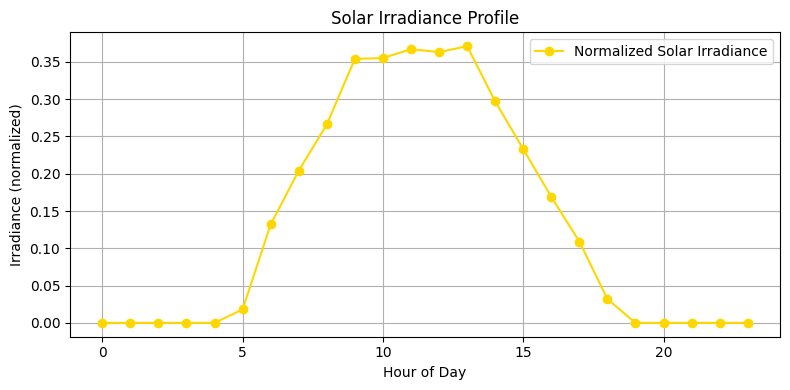

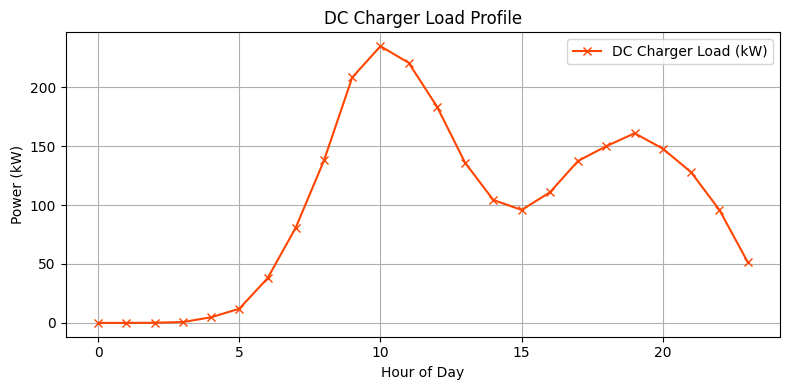

ValueError: x and y must have same first dimension, but have shapes (1,) and (24,)

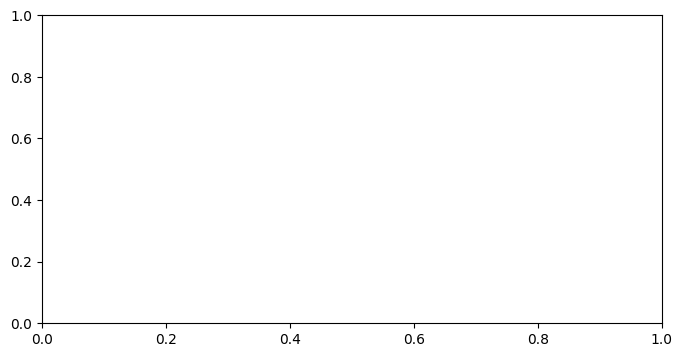

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
import plotly.graph_objs as go
import plotly.io as pio
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
def ceil_to_multiple(value, base):
    """
    返回大于等于 value 的最小 base 的倍数
    例如，value=15，base=7，则返回21,用于修改充电桩容量
    """
    import math
    return math.ceil(value / base) * base



In [ ]:
# ============================================ step1:容量定义与用户输入 ================================
# 用户输入：6个决策变量上下限 (依次是pv_ac, pv_dc, eb_ac, eb_dc, charger_ac, charger_dc)
# xl_user = np.array([float(x) for x in input("请输入6个决策变量的下限，用空格分隔(kW kW kWh kWh kW kW): \n参考示例 3000 3000 6000 6000 1000 1000").split()])
# xu_user = np.array([float(x) for x in input("请输入6个决策变量的上限，用空格分隔(kW kW kWh kWh kW kW): \n参考示例 6000 6000 10000 10000 5000 5000").split()])
# [pv_ac, pv_dc, eb_ac, eb_dc, charger_ac, charger_dc]
xl_user = np.array([900, 900, 1500, 1500, 100, 100])  # 下限（单位：kW 或 kWh）
xu_user = np.array([1200, 1200, 4000, 4000, 400, 400])  # 上限（单位：kW 或 kWh）

# 用户输入：园区占地面积  特大型储能园区：临沂市河东区光储充产业园项目，占地面积约240000平方米，总建筑面积约为340000平方米 
# park_space = float(input("园区占地面积 (平方米): \n参考示例 240000"))
park_space = 160000

if xu_user[0]+xu_user[1] > park_space*0.3*175/1000: #园区面积对光伏容量的限制，后续应该进行修改
    xu_user[0]=park_space*0.3*175/2000
    xu_user[1]=park_space*0.3*175/2000  #光伏功率上限（园区限制）
    print(f"直流侧和交流侧光伏上限修改为(kW kW):{xu_user[0]}、{xu_user[1]}")

if xl_user[0]+xl_user[1] > park_space*0.3*175/1000: #园区面积对光伏容量的限制，后续应该进行修改
    xl_user[0]=park_space*0.3*175/4000
    xl_user[1]=park_space*0.3*175/4000  #光伏功率下限（自定义，可以考虑修改）
    print(f"直流侧和交流侧光伏下限修改为(kW kW):{xl_user[0]}、{xl_user[1]}")
    
# 用户输入：典型日园区负荷均值 (单位：kW) 根据《城市电力规划规范》（GB/T50293-1999），工业用地用电指标为200-800kW/公顷。240000平方米的园区面积为24公顷，按照最低值200kW/公顷计算，负荷功率为4800kW；按照最高值800kW/公顷计算，负荷功率为19200kW。
# typical_day_avg_load = float(input("请输入典型日园区平均每小时负荷 (kW): \n根据《城市电力规划规范》（GB/T50293-1999），工业用地用电指标为200-800kW/公顷。240000平方米的园区面积为24公顷，按照最低值200kW/公顷计算，负荷功率为4800kW；按照最高值800kW/公顷计算，负荷功率为19200kW\n"))
typical_day_avg_load = 400
# 用户输入：园区车辆保有量（辆）
# car_number = int(input("请输入园区车辆保有量(辆): \n工业厂房根据标准每100平方米建筑面积配建0.2个车位，对于一个占地面积为240000平方米的园区，假设容积率为1.5，则总建筑面积为360000平方米，车辆保有量约为720个车位\n"))
car_number = 140
num_chargers = car_number // 10
ac_charger_power = 7  # 单位kW
print(f"交流充电桩（慢充）数量为(辆):{num_chargers}，充电功率为(kW)：{ac_charger_power}")

if xl_user[4] >  num_chargers*ac_charger_power:
    xl_user[4]=num_chargers*ac_charger_power*6/7
    print(f"交流侧充电桩下限修改为(kW):{xl_user[4]}")

if xu_user[4] >  num_chargers*ac_charger_power*10/7:
    xu_user[4]=num_chargers*ac_charger_power*10/7
    print(f"交流侧充电桩上限修改为(kW):{xu_user[4]}")

print(f"xl_user:{xl_user}")
print(f"xu_user:{xu_user}")



In [ ]:
# ============================================step2: 从CSV和XLSX文件读入真实数据 ============================================

n_days = 365
### 读取光照数据
solar_data = pd.read_excel('Solar_data_new.xlsx')
# 取前24行的第二列（DNI）的值
solar_irradiance = solar_data.iloc[:24, 7].values # 取第2列（平均辐射强度）
#光照数据由1天扩展到1年
solar_irradiance_year = np.tile(solar_irradiance, n_days)  # 复制365次得到8760小时
# 归一化处理（假设1000W/m²为标准最大值） 额定功率STC标准下即在1000W/m2 长度为一天
irrad_profile = solar_irradiance / 1000.0 

### 读取直流充电负荷功率数据（每0.01h一个点）
dc_charge_load_data = pd.read_csv('load_simulation_results.csv')
dc_charge_load_profile_raw = dc_charge_load_data.iloc[:, 1].values/10 #整体多除以了10
# 将负荷曲线按小时整合
sub_steps_per_hour = int(1 / 0.01)  # 100
# 每100个数据点取平均，得到每小时负荷
dc_charge_load_profile= np.mean(dc_charge_load_profile_raw.reshape(-1, sub_steps_per_hour), axis=1)
# 负荷数据由1天扩展到1年
dc_charge_load_profile_year = np.tile(dc_charge_load_profile, n_days)

max_dc_charge_load = np.max(dc_charge_load_profile)
print(f"直流充电负荷功率最大值: {max_dc_charge_load:.2f} kW")

# 直流充电桩负荷限制
if xl_user[5] <  max_dc_charge_load:
    xl_user[5]=max_dc_charge_load
    print(f"直流侧充电桩下限修改为(kW):{xl_user[5]}")

if xu_user[5] <  max_dc_charge_load*2:
    xu_user[5]=max_dc_charge_load*2
    print(f"直流侧充电桩上限修改为(kW):{xu_user[5]}")


In [ ]:
# ============================================step3: 生成园区负载曲线和交流充电负荷曲线（基于典型日负荷生成年负荷数据）============================================
len(irrad_profile)   # 光照数据对应的长度
n_hours = len(irrad_profile) * n_days
# 初始化负荷曲线
total_park_load_profile_year = np.zeros(n_hours)
random_variation = 0.05 * (np.random.rand(n_hours) - 0.5)

# 每天按照时间分配负荷
for day in range(n_days):
    for hour in range(24):
        index = day * 24 + hour
        if 9 <= hour < 18:
            total_park_load_profile_year[index] = typical_day_avg_load * (1 + random_variation[index])
        else:
            total_park_load_profile_year[index] = 0.5 * typical_day_avg_load * (1 + random_variation[index])

# 直流侧和交流侧负荷设定 #可以根据需求进行修改
ac_park_load_profile_year = total_park_load_profile_year * (5/6)
dc_park_load_profile_year = total_park_load_profile_year * (1/6) 
ac_park_load_profile = ac_park_load_profile_year[:24]
dc_park_load_profile = dc_park_load_profile_year[:24]

# 计算交流充电桩负荷曲线（9:00-18:00均匀分布）
ac_charge_load_profile_year = np.zeros(n_hours)
charging_hours = np.arange(9, 18)
for day in range(n_days):
    for hour in charging_hours:
        ac_charge_load_profile_year[day*24 + hour] = num_chargers * ac_charger_power / len(charging_hours)
ac_charge_load_profile = ac_charge_load_profile_year[:24]



In [ ]:
# ============================================step4:检查统一后的长度============================================

# 打印光照数据和负荷数据的长度
print(f"光照数据长度: {len(irrad_profile)}") #应该为24
print("光照数据（归一化后）:")
for i in range(len(irrad_profile)):
    print(f"第{i}小时: {irrad_profile[i]:.6f}")

print(f"\n直流充电桩负荷数据长度: {len(dc_charge_load_profile)}") #应该为24
print("直流充电桩负荷数据（每小时平均负荷功率）:")
for i in range(len(dc_charge_load_profile)):
    print(f"第{i}小时: {dc_charge_load_profile[i]:.6f} kW")

print(f"\n交流充电桩负荷数据长度: {len(ac_charge_load_profile)}") #应该为24
print("交流充电桩负荷数据（每小时平均负荷功率）:")
for i in range(len(ac_charge_load_profile)):
    print(f"第{i}小时: {ac_charge_load_profile[i]:.6f} kW")

# 长度一致性检查
assert len(irrad_profile) == len(dc_charge_load_profile), "光照数据和直流充电桩负荷数据长度不一致！"

# 时间步长
Delta_t = 1  # 小时
n_hours = len(irrad_profile)  # 总小时数，比如24或8760
hours = np.arange(n_hours)  # [0, 1, 2, ..., 23]

# 分别绘制光照强度与DC充电桩负荷

# 图1：光照强度
plt.figure(figsize=(8, 4))
plt.plot(hours, irrad_profile, label='Normalized Solar Irradiance', color='gold', marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Irradiance (normalized)')
plt.title('Solar Irradiance Profile')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 图2：直流充电桩负荷
plt.figure(figsize=(8, 4))
plt.plot(hours, dc_charge_load_profile, label='DC Charger Load (kW)', color='orangered', marker='x')
plt.xlabel('Hour of Day')
plt.ylabel('Power (kW)')
plt.title('DC Charger Load Profile')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# # 
# hours_1day = np.arange(len(irrad_profile))

# 绘制直流侧负载（1天）
plt.figure(figsize=(8, 4))
plt.plot(hours, dc_park_load_profile, label='DC Park Load (kW)', color='green', marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Power (kW)')
plt.title('DC Park Load - One Day')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 绘制交流侧负载（1天）
plt.figure(figsize=(8, 4))
plt.plot(hours, ac_park_load_profile, label='AC Park Load (kW)', color='blue', marker='x')
plt.xlabel('Hour of Day')
plt.ylabel('Power (kW)')
plt.title('AC Park Load - One Day')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
# ============================================step5:参数定义============================================
# 电价和碳排放因子
# electricity_price = 0.7  # 元/kWh
electricity_sell_price = 0.68  # 元/kWh
electricity_buy_price = 0.68  # 元/kWh
charge_price = 1.05  # 元/kWh
grid_co2_factor = 0.6  # kg/kWh

# 储能充放电效率
eb_charge_eff = 0.9
eb_discharge_eff = 0.9

# 各模块单价
AC_PV_system_unit_price = 4500
DC_PV_system_unit_price = 3700
#光伏系统（AC和DC光伏）单价
AC_Energy_storage_system_unit_price = 2000
DC_Energy_storage_system_unit_price = 500
#储能系统（AC和DC电池）单价 
AC_EV_charger_unit_price = 430 # 7kW约需要3k 
DC_EV_charger_unit_price = 420 # 120kW约需要5w
#充电桩（AC和DC充电桩）单价 

#年运维成本的比例
annual_maintenance_rate=0.01

# 定义储能最大充/放电功率限制（这里假定为额定容量的1倍，你可根据实际需求调整比例）
charge_rate_ratio = 0.1
discharge_rate_ratio = 0.1

# 直流侧和交流侧之间的转换效率
DC_to_AC_conversion_efficiency = 0.97
AC_to_DC_conversion_efficiency = 0.97



In [ ]:
# ============================================step6:定义优化问题============================================

class MicrogridOptimization_2(Problem): #定义一个新的类 MicrogridOptimization，继承自 pymoo.core.problem.Problem

    def __init__(self):
        super().__init__(n_var=6, n_obj=3, n_constr=0, xl=xl_user, xu=xu_user)
        #并网条件（买电不卖电）n_obj=3
        #决策变量6个 优化目标4个 没有显式约束条件 决策变量下限数组和上限数组，请注意决策变量这12个值由用户输入
    def _evaluate(self, X, out, *args, **kwargs):  
        #_evaluate为父类 Problem 中定义的“抽象方法”
        #如果你的种群规模是100，决策变量是6个，那么：X.shape = (100, 6)
        objs = []
        dc_ac_power_flow = []  #用来记录每个时刻直流与交流之间的功率流动，后续可以进行记录，绘制曲线
        #创建一个空列表 objs，用于存储每个解对应的4个目标函数值。
        for row in X:  # 全部都是24分析
            pv_ac, pv_dc, eb_ac, eb_dc, charger_ac, charger_dc = row 
            max_ac_charge_power = eb_ac * charge_rate_ratio
            max_dc_charge_power = eb_dc * charge_rate_ratio
            max_ac_discharge_power = eb_ac * discharge_rate_ratio
            max_dc_discharge_power = eb_dc * discharge_rate_ratio
            pv_power_ac = pv_ac * irrad_profile   #pv_ac kW irrad_profile 无量纲 pv_power_ac kW
            pv_power_dc = pv_dc * irrad_profile   
            #额定容量 × 归一化光照强度
            dc_load_total = dc_charge_load_profile+dc_park_load_profile   #定义的是一天的量
            ac_load_total = ac_charge_load_profile+ac_park_load_profile   #定义的是一天的量
            load_total = ac_load_total+dc_load_total   #定义的是一天的量
            #总的负荷功率需求，直接取之前处理好的逐小时负荷
            soc_ac = eb_ac / 2
            soc_dc = eb_dc / 2
            #假设一开始电池电量为额定容量的50% 
            grid_energy = 0
            pv_wasted_ac = 0
            pv_wasted_dc = 0
            pv_wasted = 0
            pv_curtailment = 0
            total_pv_generated = 0
            total_pv_used = 0
            missing_energy = 0  
            #各类累积量的初始化（电网购电量、光伏浪费量、光伏总发电量、光伏实际利用量、供电缺口累计量）
            for t in range(24):
                pv_wasted=0
                pv_wasted_ac=0
                pv_wasted_dc=0
                flag_max_dc_discharge_power = max_dc_discharge_power
                flag_max_ac_discharge_power = max_ac_discharge_power
                flag_max_dc_charge_power = max_dc_charge_power
                flag_max_ac_charge_power = max_ac_charge_power
                total_pv_generated += (pv_total_ac + pv_total_dc)
                # 计算当时电价倍率
                if (8 <= t < 11) or (13 <= t < 17):
                    price_factor = 1.5  # 峰价，上浮50% 8点-11点，13点-17点
                elif (0 <= t < 8) or (11 <= t < 13):
                    price_factor = 0.5  # 谷价，下浮50% 0点-8点，11点-13点
                else:
                    price_factor = 1.0  # 平价 17点-24点   
                current_sell_price = electricity_sell_price * price_factor
                current_buy_price = electricity_buy_price * price_factor

                print(f"time[{t}]")
                pv_total_ac = pv_power_ac[t]
                pv_total_dc = pv_power_dc[t]
                load_dc = dc_load_total[t]
                load_ac = ac_load_total[t]
                flag_max_dc_discharge_power = max_dc_discharge_power
                flag_max_ac_discharge_power = max_ac_discharge_power
                flag_max_dc_charge_power = max_dc_charge_power
                flag_max_ac_charge_power = max_ac_charge_power
                total_pv_generated += (pv_total_ac + pv_total_dc)

                # 先用直流光伏满足直流负荷
                supply_dc = min(pv_total_dc, load_dc)
                pv_total_dc -= supply_dc
                load_dc -= supply_dc

                # 再用交流光伏满足交流负荷
                supply_ac = min(pv_total_ac, load_ac)
                pv_total_ac -= supply_ac
                load_ac -= supply_ac
                
                total_pv_used += (supply_dc + supply_ac)

                # ========== 一侧富余支援另一侧负载 ==========
                if pv_total_ac > 0 and load_dc > 0:
                    support_dc = min(pv_total_ac*AC_to_DC_conversion_efficiency, load_dc)
                    pv_total_ac -= support_dc/AC_to_DC_conversion_efficiency
                    load_dc -= support_dc
                    total_pv_used += support_dc/AC_to_DC_conversion_efficiency

                if pv_total_dc > 0 and load_ac > 0:
                    support_ac = min(pv_total_dc*DC_to_AC_conversion_efficiency, load_ac)
                    pv_total_dc -= support_ac/DC_to_AC_conversion_efficiency
                    load_ac -= support_ac
                    total_pv_used += support_ac/DC_to_AC_conversion_efficiency

                # ========== 电池放电供负荷 ==========
                if load_dc > 0:
                    if soc_dc >  0.1 * eb_dc:  # Ensure SOC is above 10% before discharging
                        # 增加放电功率上限约束
                        max_release = min(flag_max_dc_discharge_power, (soc_dc-0.1*eb_dc) / Delta_t)
                        release = min(load_dc / eb_discharge_eff, max_release)
                        flag_max_dc_discharge_power -= release
                        soc_dc -= release * Delta_t
                        print(f"time[{t}-1]:soc_dc {soc_dc}")
                        load_dc -= release * eb_discharge_eff

                if load_ac > 0:
                    if soc_ac > 0.1 * eb_ac:
                        max_release = min(flag_max_ac_discharge_power, (soc_ac-0.1*eb_ac)  / Delta_t)
                        release = min(load_ac / eb_discharge_eff, max_release)
                        flag_max_ac_discharge_power -= release
                        soc_ac -= release * Delta_t
                        print(f"time[{t}-1]:soc_ac {soc_ac}")
                        load_ac -= release * eb_discharge_eff

                # ========== 电池放电供另一侧负荷 ==========
                if load_dc > 0:
                    if load_dc > 0 and soc_ac > 0.1 * eb_ac:
                        max_release = min(flag_max_ac_discharge_power, (soc_ac-0.1*eb_ac) / Delta_t)
                        release = min(load_dc / eb_discharge_eff, max_release*AC_to_DC_conversion_efficiency)
                        flag_max_ac_discharge_power -= release/AC_to_DC_conversion_efficiency
                        soc_ac -= release/AC_to_DC_conversion_efficiency * Delta_t
                        print(f"time[{t}-2]:soc_ac {soc_ac}")
                        load_dc -= release * eb_discharge_eff

                if load_ac > 0:
                    if load_ac > 0 and soc_dc > 0.1 * eb_dc:
                        max_release = min(flag_max_dc_discharge_power, (soc_dc-0.1*eb_dc)  / Delta_t)
                        release = min(load_ac / eb_discharge_eff, max_release*DC_to_AC_conversion_efficiency)
                        flag_max_dc_discharge_power -= release/DC_to_AC_conversion_efficiency
                        soc_dc -= release/DC_to_AC_conversion_efficiency * Delta_t
                        print(f"time[{t}-2]:soc_dc {soc_dc}")
                        load_ac -= release * eb_discharge_eff

                # 储能放电后仍有剩余负荷则用电网买电
                if load_ac + load_dc > 0:
                    grid_energy += (load_dc/AC_to_DC_conversion_efficiency + load_ac) * Delta_t

                # 储能充放电逻辑，分时段严格控制
                if price_factor == 0.5:
                    # 谷价时段，只能充电（买电）  0点-8点，11点-13点
                    # 尽量充满储能，优先用光伏余电充电
                    # 如果光伏余电不够，且储能还缺电的话，再用电网买电充电
                    flag_max_ac_charge_power = max_ac_charge_power + max_ac_discharge_power - flag_max_ac_discharge_power
                    flag_max_dc_charge_power = max_dc_charge_power + max_dc_discharge_power - flag_max_dc_charge_power
                    # AC储能充电
                    if soc_ac < 0.9 * eb_ac and flag_max_ac_charge_power > 0:
                        print("AC储能充电")
                        available_pv_power = min(pv_total_ac, flag_max_ac_charge_power)
                        delta_energy_pv = min((0.9*eb_ac - soc_ac), available_pv_power * eb_charge_eff * Delta_t)
                        flag_max_ac_charge_power -= delta_energy_pv/eb_charge_eff
                        soc_ac += delta_energy_pv
                        pv_total_ac -= delta_energy_pv / (eb_charge_eff * Delta_t)

                        # 光伏余电不够时买电充电
                        remaining_energy = min((0.9*eb_ac - soc_ac), flag_max_ac_charge_power * eb_charge_eff * Delta_t )

                        if remaining_energy > 0:
                            grid_charge = min(remaining_energy,flag_max_ac_charge_power)
                            flag_max_ac_charge_power -= grid_charge/eb_charge_eff
                            soc_ac += grid_charge
                            grid_energy += price_factor * grid_charge / eb_charge_eff  # 买电充电，grid_energy累计正值
            


                    # DC储能充电
                    if soc_dc < 0.9 * eb_dc and flag_max_dc_charge_power > 0:
                        available_pv_power = min(pv_total_dc, flag_max_dc_charge_power)
                        delta_energy_pv = min((0.9*eb_dc - soc_dc), available_pv_power * eb_charge_eff * Delta_t)
                        soc_dc += delta_energy_pv
                        flag_max_dc_charge_power -= delta_energy_pv/eb_charge_eff                        
                        pv_total_dc -= delta_energy_pv / (eb_charge_eff * Delta_t)

                        remaining_energy = min((0.9*eb_dc - soc_dc), flag_max_dc_charge_power * eb_charge_eff * Delta_t )
                        if remaining_energy > 0:
                            grid_charge = min(remaining_energy,flag_max_dc_charge_power)
                            flag_max_dc_charge_power -= grid_charge/eb_charge_eff
                            soc_dc += grid_charge
                            grid_energy += price_factor * remaining_energy / eb_charge_eff / AC_to_DC_conversion_efficiency # 买电充电

                    # 光伏剩余卖电 (用弃光率替代)
                    pv_wasted= pv_total_ac + pv_total_dc 
                    # grid_energy -= price_factor * (pv_total_ac + pv_total_dc*DC_to_AC_conversion_efficiency) * Delta_t

                # 峰价时段，只能放电（卖电）8点-11点，13点-17点
                elif price_factor == 1.5:
                    # 光伏剩余卖电(用弃光率替代)
                    pv_wasted= pv_total_ac + pv_total_dc 
                    # grid_energy -= price_factor * (pv_total_ac + pv_total_dc*DC_to_AC_conversion_efficiency) * Delta_t

                    # **储能剩余可放电部分卖电**
                    # AC储能剩余可放电功率（以放电功率上限和SOC决定）
                    # remaining_ac_discharge_power = min(flag_max_ac_discharge_power, (soc_ac - 0.1*eb_ac) / Delta_t)
                    # remaining_ac_discharge_energy = remaining_ac_discharge_power * Delta_t
                    # flag_max_ac_discharge_power -= remaining_ac_discharge_energy
                    # # DC储能剩余可放电功率
                    # remaining_dc_discharge_power = min(flag_max_dc_discharge_power, (soc_dc-0.1*eb_dc) / Delta_t)
                    # remaining_dc_discharge_energy = remaining_dc_discharge_power * Delta_t
                    # flag_max_dc_discharge_power -= remaining_dc_discharge_energy 
                    # # 卖电（储能放电卖电时按放电效率计）
                    # # 注意这里将放电量按放电效率换算为电网卖电能量
                    # sell_energy = (remaining_ac_discharge_energy + remaining_dc_discharge_energy*DC_to_AC_conversion_efficiency) * eb_discharge_eff
                    # if sell_energy > 0:
                    #     # 储能放电卖电，卖电量用负数表示，grid_energy负数代表卖电
                    #     grid_energy -= sell_energy * price_factor
                    #     # 储能SOC扣除这部分卖电能量对应的电量（效率反算）
                    #     soc_ac -= remaining_ac_discharge_energy
                    #     soc_dc -= remaining_dc_discharge_energy
                # 平价时段，储能可充可放（功率跟踪）17点-24点
                else:
                    flag_max_ac_charge_power = max_ac_charge_power + max_ac_discharge_power - flag_max_ac_discharge_power
                    flag_max_dc_charge_power = max_dc_charge_power + max_dc_discharge_power - flag_max_dc_charge_power
                    # 充电（优先光伏余电）
                    if soc_ac < 0.9*eb_ac and pv_total_ac > 0 and flag_max_ac_charge_power > 0:
                        available_power = min(pv_total_ac, flag_max_ac_charge_power)
                        delta_energy = min((0.9*eb_ac - soc_ac), available_power * Delta_t)
                        flag_max_ac_charge_power -= delta_energy
                        soc_ac += delta_energy* eb_charge_eff
                        pv_total_ac -= delta_energy / (eb_charge_eff * Delta_t)

                    if soc_dc < 0.9*eb_dc and pv_total_dc > 0 and flag_max_dc_charge_power > 0:
                        available_power = min(pv_total_dc, flag_max_dc_charge_power)
                        delta_energy = min((0.9*eb_dc - soc_dc), available_power * Delta_t)
                        flag_max_dc_charge_power -= delta_energy
                        soc_dc += delta_energy* eb_charge_eff
                        pv_total_dc -= delta_energy / Delta_t
                    
                    if pv_total_dc > 0 and pv_total_ac == 0 and flag_max_ac_charge_power > 0:  #说明dc侧储能已充满，ac侧储能已充但未满
                        if soc_ac < 0.9 * eb_ac:                        
                            max_release = min( pv_total_dc * DC_to_AC_conversion_efficiency , flag_max_ac_charge_power)
                            ac_charge = max_release * eb_charge_eff
                            if soc_ac + ac_charge * Delta_t > 0.9*eb_ac:
                                pv_total_dc=pv_total_dc-(0.9*eb_ac-soc_ac)/eb_charge_eff/DC_to_AC_conversion_efficiency
                                total_pv_used +=(0.9*eb_ac-soc_ac)/eb_charge_eff/DC_to_AC_conversion_efficiency
                                soc_ac=0.9*eb_ac
                                flag_max_ac_charge_power -= (0.9*eb_ac-soc_ac)/eb_charge_eff
                            else:
                                soc_ac=soc_ac + ac_charge * Delta_t
                                flag_max_ac_charge_power -= ac_charge/eb_charge_eff
                                total_pv_used +=pv_total_dc
                                pv_total_dc=0
                        else:
                            pv_total_dc=pv_total_dc

                    if pv_total_ac > 0 and pv_total_dc == 0 and flag_max_dc_charge_power > 0:  #说明ac侧储能已充满，dc侧储能已充但未满
                        if soc_dc <  0.9* eb_dc:                        
                            max_release = min (pv_total_ac * AC_to_DC_conversion_efficiency , flag_max_dc_charge_power)
                            dc_charge = eb_charge_eff * max_release
                            if soc_dc + dc_charge * Delta_t >  0.9* eb_dc:
                                pv_total_ac=pv_total_ac-( 0.9* eb_dc-soc_dc)/eb_charge_eff/AC_to_DC_conversion_efficiency
                                total_pv_used +=( 0.9* eb_dc-soc_dc)/eb_charge_eff/AC_to_DC_conversion_efficiency
                                soc_dc= 0.9* eb_dc
                                flag_max_dc_charge_power -= ( 0.9* eb_dc-soc_dc)/eb_charge_eff
                            else:
                                soc_dc=soc_dc + dc_charge * Delta_t
                                flag_max_dc_charge_power -= ac_charge/eb_charge_eff   
                                total_pv_used +=pv_total_ac
                                pv_total_ac=0
                        else:
                            pv_total_ac=pv_total_ac

                    # 光伏剩余卖电(用弃光率替代)
                    pv_wasted = pv_total_ac + pv_total_dc 


            #========== 评价指标构建（并网状态） ==========
            investment_cost = AC_EV_charger_unit_price/24 * pv_ac + DC_EV_charger_unit_price/24* pv_dc + 3*AC_Energy_storage_system_unit_price/8 * eb_ac + 3*DC_Energy_storage_system_unit_price/8 * eb_dc + AC_EV_charger_unit_price/24 * charger_ac +DC_EV_charger_unit_price/24* charger_dc
            #总投资成本 = 光伏系统成本 + 储能系统成本 + 充电桩系统成本
            #光伏系统（AC和DC光伏）单价 = 4500 3700 元/千瓦（kW）
            #储能系统（AC和DC电池）单价 = 600 元/千瓦时（kWh）（八年更新，因此需要更新两次）
            #充电桩（AC和DC充电桩）单价 = 500 元/千瓦（kW）            
            maintenance_cost = annual_maintenance_rate * investment_cost
            #每年运维成本 = 投资成本的 1%
            electricity_cost = grid_energy * current_buy_price
            revenue = np.sum(dc_charge_load_profile) * charge_price
            #充电收入 充电服务收费标准 = 0.7 元/kWh
            total_cost = investment_cost + maintenance_cost + electricity_cost - revenue  #这个指标低比较好
            print(f"investment_cost={investment_cost}CNY\nmaintenance_cost={maintenance_cost}CNY\nrevenue={revenue}CNY\ntotal_cost={total_cost}CNY")
            #年化总成本
            co2_emission = grid_energy * grid_co2_factor
            pv_utilization = total_pv_used / total_pv_generated if total_pv_generated > 0 else 0

            if pv_utilization <= 1 :
                objs.append([total_cost, co2_emission, 1 - pv_utilization])
            else:
                objs.append([1e9, 1e9, 1.0])  # 设为劣解，强迫排除

        out["F"] = np.array(objs)

# ============================================
# 配置与运行 NSGA-II
# ============================================

pop_size = 100 #种群个数 # 这里可以根据需要调整种群规模
problem = MicrogridOptimization_2()

algorithm = NSGA2(
    pop_size=pop_size,
)

res = minimize(
    problem,
    algorithm,
    ('n_gen', 100),
    seed=1,
    verbose=True
)

# 输出前5个帕累托解 + 打印上下限范围
print("用户自定义的决策变量范围：")
print(f"光伏AC容量: {xl_user[0]} ~ {xu_user[0]} kW")
print(f"光伏DC容量: {xl_user[1]} ~ {xu_user[1]} kW")
print(f"储能AC容量: {xl_user[2]} ~ {xu_user[2]} kWh")
print(f"储能DC容量: {xl_user[3]} ~ {xu_user[3]} kWh")
print(f"充电桩AC容量: {xl_user[4]} ~ {xu_user[4]} kW")
print(f"充电桩DC容量: {xl_user[5]} ~ {xu_user[5]} kW")

Scatter().add(res.F).show()

#========== 评价指标构建（离网状态） ==========
# 提取三个目标函数值
f1 = res.F[:, 0]  # 年化总成本
f2 = res.F[:, 1]  # 碳排放量
f3 = res.F[:, 2]  # 1 - 光伏消纳率

# 解的容量（6个决策变量）
pv_ac     = res.X[:, 0]
pv_dc     = res.X[:, 1]
eb_ac     = res.X[:, 2]
eb_dc     = res.X[:, 3]
charger_ac = res.X[:, 4]
charger_dc = res.X[:, 5]
print(f1)
print(f2)
print(f3)
print(len(f1), len(f2), len(f3))


# fig.show()
# 创建交互式3D散点图
fig = go.Figure(data=[go.Scatter(
    x=f1,
    y=f2,
    # z=f3,
    mode='markers',
    marker=dict(
        size=6,
        color='blue',
        opacity=0.7
    ),
    text=[
        f"方案 {i+1}<br>Total Cost: {f1[i]:,.1f} CNY<br>CO₂: {f2[i]:,.1f} kg"
        for i in range(len(f1))
    ],
    hoverinfo='text'
)])

# 设置布局
fig.update_layout(
    title='Pareto Front: Cost vs CO₂ Emissions (2D Interactive View)',
    xaxis_title='Annualized Total Cost (CNY)',
    yaxis_title='CO₂ Emissions (kg)',
    width=800,
    height=600
)


# 显示
fig.show()

# 构建 DataFrame
df_grid= pd.DataFrame({
    "方案编号": [f"方案{i+1}" for i in range(pop_size)],
    "年化总成本 (CNY)": f1,
    "碳排放量 (kg)": f3,
    "PV_AC 容量 (kW)": pv_ac,
    "PV_DC 容量 (kW)": pv_dc,
    "EB_AC 容量 (kWh)": eb_ac,
    "EB_DC 容量 (kWh)": eb_dc,
    "Charger_AC 容量 (kW)": charger_ac,
    "Charger_DC 容量 (kW)": charger_dc
})
# pv_ac, pv_dc, eb_ac, eb_dc, charger_ac, charger_dc = res.X[choice]
# 设置本地保存路径
local_path = r"C:\Users\86183\Desktop\111"
os.makedirs(local_path, exist_ok=True)
grid_result_path = os.path.join(local_path, "Grid_Optimization_Results.xlsx")

# 导出为 Excel 文件
df_grid.to_excel(grid_result_path, index=False)

grid_result_path

# 显示已有方案数量
num_solutions = len(res.X)
print(f"共找到 {num_solutions} 个优化方案。")

# 让用户输入要查看的方案编号（1 到 num_solutions）
while True:
    # 1. 让用户输入要查看的方案编号
    choice_grid = input(f"请输入要查看的并网方案编号 (1-{num_solutions}): ")
    if not (choice_grid.isdigit() and 1 <= int(choice_grid) <= num_solutions):
        print("输入无效，请重新输入。")
        continue
    choice_grid = int(choice_grid) - 1

    # 取用户选的方案
    pv_ac, pv_dc, eb_ac, eb_dc, charger_ac, charger_dc = res.X[choice_grid]

    print("===== 你选择的方案容量配置 =====")
    print(f"光伏AC容量: {pv_ac:.2f} kW")
    print(f"光伏DC容量: {pv_dc:.2f} kW")
    print(f"储能AC容量: {eb_ac:.2f} kWh")
    print(f"储能DC容量: {eb_dc:.2f} kWh")
    print(f"充电桩AC容量: {charger_ac:.2f} kW")
    print(f"充电桩DC容量: {charger_dc:.2f} kW")
    print("===============================")
    max_ac_charge_power = eb_ac * charge_rate_ratio
    max_dc_charge_power = eb_dc * charge_rate_ratio
    max_ac_discharge_power = eb_ac * discharge_rate_ratio
    max_dc_discharge_power = eb_dc * discharge_rate_ratio
    pv_power_ac = pv_ac * irrad_profile   #pv_ac kW irrad_profile 无量纲 pv_power_ac kW
    pv_power_dc = pv_dc * irrad_profile   
    #额定容量 × 归一化光照强度
    dc_load_total = dc_charge_load_profile+dc_park_load_profile   #dc_park_load_profile还需要进行定义
    ac_load_total = ac_charge_load_profile+ac_park_load_profile   #ac_charge_load_profile ac_park_load_profile还需要进行定义
    load_total=ac_load_total+dc_load_total
    # 初始化储能SOC数组（每小时）
    soc_ac_array = np.zeros(n_hours)
    soc_dc_array = np.zeros(n_hours)
    grid_energy_profile = np.zeros(n_hours)  # 每小时电网买卖功率，买电为正，卖电为负
    pv_curtailment_profile = np.zeros(n_hours)  # 每小时电网买卖功率，买电为正，卖电为负

    #总的负荷功率需求，直接取之前处理好的逐小时负荷
    soc_ac = eb_ac / 2
    soc_dc = eb_dc / 2
    #假设一开始电池电量为额定容量的50% 
    grid_energy = 0
    pv_wasted_ac = 0
    pv_wasted_dc = 0
    pv_wasted = 0
    pv_curtailment = 0
    total_pv_generated = 0
    total_pv_used = 0
    missing_energy = 0  
    #各类累积量的初始化（电网购电量、光伏浪费量、光伏总发电量、光伏实际利用量、供电缺口累计量）

    for t in range(n_hours):
        grid_energy_hour=0
        pv_curtailment_hour=0
        pv_wasted=0
        pv_wasted_ac=0
        pv_wasted_dc=0
        # hour = t % 24  # 当前小时（0-23）
        # soc_ac_array[t] = soc_ac
        # soc_dc_array[t] = soc_dc
        pv_total_ac = pv_power_ac[t]
        pv_total_dc = pv_power_dc[t]
        load_dc = dc_load_total[t]
        load_ac = ac_load_total[t]
        flag_max_dc_discharge_power = max_dc_discharge_power
        flag_max_ac_discharge_power = max_ac_discharge_power
        flag_max_dc_charge_power = max_dc_charge_power
        flag_max_ac_charge_power = max_ac_charge_power
        total_pv_generated += (pv_total_ac + pv_total_dc)
        hour = t % 24  # 当前小时（0-23）
        # 计算当时电价倍率
        if (8 <= hour < 11) or (13 <= hour < 17):
            price_factor = 1.5  # 峰价，上浮50% 8点-11点，13点-17点
        elif (0 <= hour < 8) or (11 <= hour < 13):
            price_factor = 0.5  # 谷价，下浮50% 0点-8点，11点-13点
        else:
            price_factor = 1.0  # 平价 17点-24点

        current_sell_price = electricity_sell_price * price_factor
        current_buy_price = electricity_buy_price * price_factor

        pv_total_ac = pv_power_ac[t]
        pv_total_dc = pv_power_dc[t]
        load_dc = dc_load_total[t]
        load_ac = ac_load_total[t]

        total_pv_generated += (pv_total_ac + pv_total_dc)

        # 光伏先满足负荷
        supply_dc = min(pv_total_dc, load_dc)
        pv_total_dc -= supply_dc
        load_dc -= supply_dc

        supply_ac = min(pv_total_ac, load_ac)
        pv_total_ac -= supply_ac
        load_ac -= supply_ac

        total_pv_used += (supply_dc + supply_ac)

        # 光伏余电跨侧供负荷
        if pv_total_ac > 0 and load_dc > 0:
            support_dc = min(pv_total_ac*AC_to_DC_conversion_efficiency, load_dc)
            pv_total_ac -= support_dc/AC_to_DC_conversion_efficiency
            load_dc -= support_dc
            total_pv_used += support_dc/AC_to_DC_conversion_efficiency

        if pv_total_dc > 0 and load_ac > 0:
            support_ac = min(pv_total_dc*DC_to_AC_conversion_efficiency, load_ac)
            pv_total_dc -= support_ac/DC_to_AC_conversion_efficiency
            load_ac -= support_ac
            total_pv_used += support_ac/DC_to_AC_conversion_efficiency


        # DC负荷用DC储能放电
        if load_dc > 0 :
            if soc_dc >  0.1 * eb_dc:  # Ensure SOC is above 10% before discharging
                # 增加放电功率上限约束
                max_release = min(flag_max_dc_discharge_power, (soc_dc-0.1*eb_dc) / Delta_t)
                release = min(load_dc / eb_discharge_eff, max_release)
                flag_max_dc_discharge_power -= release
                soc_dc -= release * Delta_t
                load_dc -= release * eb_discharge_eff

        # AC负荷用AC储能放电
        if load_ac > 0 :
            if soc_ac > 0.1 * eb_ac:
                max_release = min(flag_max_ac_discharge_power, (soc_ac-0.1*eb_ac)  / Delta_t)
                release = min(load_ac / eb_discharge_eff, max_release)
                flag_max_ac_discharge_power -= release
                soc_ac -= release * Delta_t
                load_ac -= release * eb_discharge_eff

        # 剩余DC负荷用AC储能放电
        if load_dc > 0 :
            if load_dc > 0 and soc_ac > 0.1 * eb_ac:
                max_release = min(flag_max_ac_discharge_power, (soc_ac-0.1*eb_ac) / Delta_t)
                release = min(load_dc / eb_discharge_eff, max_release*AC_to_DC_conversion_efficiency)
                flag_max_ac_discharge_power -= release/AC_to_DC_conversion_efficiency
                soc_ac -= release/AC_to_DC_conversion_efficiency * Delta_t
                load_dc -= release * eb_discharge_eff

        # 剩余AC负荷用DC储能放电
        if load_ac > 0 :
            if load_ac > 0 and soc_dc > 0.1 * eb_dc:
                max_release = min(flag_max_dc_discharge_power, (soc_dc-0.1*eb_dc)  / Delta_t)
                release = min(load_ac / eb_discharge_eff, max_release*DC_to_AC_conversion_efficiency)
                flag_max_dc_discharge_power -= release/DC_to_AC_conversion_efficiency
                soc_dc -= release/DC_to_AC_conversion_efficiency * Delta_t
                load_ac -= release * eb_discharge_eff

        # 储能放电后仍有剩余负荷则用电网买电
        if load_ac + load_dc > 0:
            grid_energy_hour += (load_dc/AC_to_DC_conversion_efficiency + load_ac) * Delta_t    #电网买电


        
        # 储能充放电逻辑，分时段严格控制
        if price_factor == 0.5:
            # 谷价时段，只能充电（买电）  0点-8点，11点-13点
            # 尽量充满储能，优先用光伏余电充电
            # 如果光伏余电不够，且储能还缺电的话，再用电网买电充电

            # AC储能充电
            if soc_ac < 0.9 * eb_ac and flag_max_ac_charge_power > 0:
                available_pv_power = min(pv_total_ac, flag_max_ac_charge_power)
                delta_energy_pv = min((0.9*eb_ac- soc_ac), available_pv_power * eb_charge_eff * Delta_t)
                flag_max_ac_charge_power -= delta_energy_pv/eb_charge_eff
                soc_ac += delta_energy_pv
                pv_total_ac -= delta_energy_pv / (eb_charge_eff * Delta_t)

                # 光伏余电不够时买电充电
                remaining_energy = min((0.9*eb_ac - soc_ac), flag_max_ac_charge_power * eb_charge_eff * Delta_t )
                if remaining_energy > 0:
                    grid_charge = min(remaining_energy,flag_max_ac_charge_power)
                    flag_max_ac_charge_power -= grid_charge/eb_charge_eff
                    soc_ac += grid_charge
                    grid_energy_hour += price_factor * grid_charge / eb_charge_eff  # 买电充电，grid_energy累计正值

            # DC储能充电
            if soc_dc < 0.9 * eb_dc and flag_max_dc_charge_power > 0:
                available_pv_power = min(pv_total_dc, flag_max_dc_charge_power)
                delta_energy_pv = min((0.9*eb_dc - soc_dc), available_pv_power * eb_charge_eff * Delta_t)
                soc_dc += delta_energy_pv
                pv_total_dc -= delta_energy_pv / (eb_charge_eff * Delta_t)

                remaining_energy = min((0.9*eb_dc - soc_dc), flag_max_dc_charge_power * eb_charge_eff * Delta_t )
                if remaining_energy > 0:
                    grid_charge = min(remaining_energy,flag_max_dc_charge_power)
                    flag_max_dc_charge_power -= grid_charge/eb_charge_eff
                    soc_dc += grid_charge
                    grid_energy_hour += price_factor * remaining_energy / eb_charge_eff / AC_to_DC_conversion_efficiency # 买电充电

            # 光伏剩余卖电
            grid_energy_hour -= (pv_total_ac + pv_total_dc*DC_to_AC_conversion_efficiency) * Delta_t

        # 峰价时段，只能放电（卖电）8点-11点，13点-17点
        elif price_factor == 1.5:
            # 光伏剩余卖电
            grid_energy_hour -= price_factor*(pv_total_ac + pv_total_dc*DC_to_AC_conversion_efficiency) * Delta_t

            # **储能剩余可放电部分卖电**
            # AC储能剩余可放电功率（以放电功率上限和SOC决定）
            remaining_ac_discharge_power = min(flag_max_ac_discharge_power, (soc_ac - 0.1*eb_ac) / Delta_t)
            remaining_ac_discharge_energy = remaining_ac_discharge_power * Delta_t
            flag_max_ac_discharge_power -= remaining_ac_discharge_energy
            # DC储能剩余可放电功率
            remaining_dc_discharge_power = min(flag_max_dc_discharge_power, (soc_dc-0.1*eb_dc) / Delta_t)
            remaining_dc_discharge_energy = remaining_dc_discharge_power * Delta_t
            flag_max_dc_discharge_power -= remaining_dc_discharge_energy 
            # 卖电（储能放电卖电时按放电效率计）
            # 注意这里将放电量按放电效率换算为电网卖电能量
            sell_energy = (remaining_ac_discharge_energy + remaining_dc_discharge_energy*DC_to_AC_conversion_efficiency) * eb_discharge_eff
            if sell_energy > 0:
                # 储能放电卖电，卖电量用负数表示，grid_energy负数代表卖电
                grid_energy_hour -= price_factor * sell_energy
                # 储能SOC扣除这部分卖电能量对应的电量（效率反算）
                soc_ac -= remaining_ac_discharge_energy
                soc_dc -= remaining_dc_discharge_energy
        # 平价时段，储能可充可放（功率跟踪）17点-24点
        else:
            # 充电（优先光伏余电）
            if soc_ac < 0.9*eb_ac and pv_total_ac > 0 and flag_max_ac_charge_power > 0:
                available_power = min(pv_total_ac, flag_max_ac_charge_power)
                delta_energy = min((0.9*eb_ac - soc_ac), available_power * Delta_t)
                flag_max_ac_charge_power -= delta_energy
                soc_ac += delta_energy* eb_charge_eff
                pv_total_ac -= delta_energy / (eb_charge_eff * Delta_t)

            if soc_dc < 0.9*eb_dc and pv_total_dc > 0 and flag_max_dc_charge_power > 0:
                available_power = min(pv_total_dc, flag_max_dc_charge_power)
                delta_energy = min((0.9*eb_dc - soc_dc), available_power * Delta_t)
                flag_max_dc_charge_power -= delta_energy
                soc_dc += delta_energy* eb_charge_eff
                pv_total_dc -= delta_energy / Delta_t
            
            if pv_total_dc > 0 and pv_total_ac == 0 and flag_max_ac_charge_power > 0:  #说明dc侧储能已充满，ac侧储能已充但未满
                if soc_ac < 0.9 * eb_ac:                        
                    max_release = min( pv_total_dc * DC_to_AC_conversion_efficiency , flag_max_ac_charge_power)
                    ac_charge = max_release * eb_charge_eff
                    if soc_ac + ac_charge * Delta_t > 0.9*eb_ac:
                        pv_total_dc=pv_total_dc-(0.9*eb_ac-soc_ac)/eb_charge_eff/DC_to_AC_conversion_efficiency
                        total_pv_used +=(0.9*eb_ac-soc_ac)/eb_charge_eff/DC_to_AC_conversion_efficiency
                        soc_ac=0.9*eb_ac
                        flag_max_ac_charge_power -= (0.9*eb_ac-soc_ac)/eb_charge_eff
                    else:
                        soc_ac=soc_ac + ac_charge * Delta_t
                        flag_max_ac_charge_power -= ac_charge/eb_charge_eff
                        total_pv_used +=pv_total_dc
                        pv_total_dc=0
                else:
                    pv_total_dc=pv_total_dc

            if pv_total_ac > 0 and pv_total_dc == 0 and flag_max_dc_charge_power > 0:  #说明ac侧储能已充满，dc侧储能已充但未满
                if soc_dc <  0.9* eb_dc:                        
                    max_release = min (pv_total_ac * AC_to_DC_conversion_efficiency , flag_max_dc_charge_power)
                    dc_charge = eb_charge_eff * max_release
                    if soc_dc + dc_charge * Delta_t >  0.9* eb_dc:
                        pv_total_ac=pv_total_ac-( 0.9* eb_dc-soc_dc)/eb_charge_eff/AC_to_DC_conversion_efficiency
                        total_pv_used +=( 0.9* eb_dc-soc_dc)/eb_charge_eff/AC_to_DC_conversion_efficiency
                        soc_dc= 0.9* eb_dc
                        flag_max_dc_charge_power -= ( 0.9* eb_dc-soc_dc)/eb_charge_eff
                    else:
                        soc_dc=soc_dc + dc_charge * Delta_t
                        flag_max_dc_charge_power -= ac_charge/eb_charge_eff   
                        total_pv_used +=pv_total_ac
                        pv_total_ac=0
                else:
                    pv_total_ac=pv_total_ac

            # 光伏剩余卖电
            grid_energy_hour -= (pv_total_ac + pv_total_dc/DC_to_AC_conversion_efficiency) * Delta_t
            
        grid_energy += grid_energy_hour
        # 记录SOC
        soc_ac_array[t] = soc_ac
        soc_dc_array[t] = soc_dc
        grid_energy_profile[t] = grid_energy_hour

    # 绘图
    time_hours = np.arange(n_hours)


    plt.figure(figsize=(12, 6))
    plt.plot(time_hours, soc_ac_array, label='SOC AC Battery (kWh)')
    plt.xticks(time_hours)  # 设置横坐标显示所有小时数
    plt.xlabel('Hour')
    plt.ylabel('State of Charge (kWh)')
    plt.title('SOC of AC Battery Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(time_hours, soc_dc_array, label='SOC DC Battery (kWh)')
    plt.xticks(time_hours)  # 设置横坐标显示所有小时数
    plt.xlabel('Hour')
    plt.ylabel('State of Charge (kWh)')
    plt.title('SOC of DC Battery Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(12, 6))
    plt.plot(time_hours, pv_power_ac, label='PV AC Power (kW)')
    plt.xticks(time_hours)  # 设置横坐标显示所有小时数
    plt.xlabel('Hour')
    plt.ylabel('Power (kW)')
    plt.title('PV AC Power Profile')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(time_hours, pv_power_dc, label='PV DC Power (kW)')
    plt.xticks(time_hours)  # 设置横坐标显示所有小时数
    plt.xlabel('Hour')
    plt.ylabel('Power (kW)')
    plt.title('PV DC Power Profile')
    plt.legend()
    plt.grid(True)
    plt.show()

    ac_load_24 = ac_load_total[:24]
    dc_load_24 = dc_load_total[:24]
    grid_energy_24 = grid_energy_profile[:24]
    # 画图时用 ac_load_24 和 dc_load_24

    plt.figure(figsize=(12, 6))
    plt.plot(time_hours, ac_load_24, label='AC Load (kW)')
    plt.xticks(time_hours)  # 设置横坐标显示所有小时数
    plt.xlabel('Hour')
    plt.ylabel('Load Power (kW)')
    plt.title('AC Load Power Profile')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(time_hours, dc_load_24, label='DC Load (kW)')
    plt.xticks(time_hours)  # 设置横坐标显示所有小时数
    plt.xlabel('Hour')
    plt.ylabel('Load Power (kW)')
    plt.title('DC Load Power Profile')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(time_hours, grid_energy_24, label='Grid Energy (kW)') # 每小时电网买卖功率，买电为正，卖电为负
    plt.xticks(time_hours)  # 设置横坐标显示所有小时数
    plt.xlabel('Hour')
    plt.ylabel('Grid Power (kW)')
    plt.title('Grid Energy Profile')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 本地保存路径
    local_base_path = r"C:\Users\86183\Desktop\111"

    # 创建路径（如果不存在）
    os.makedirs(local_base_path, exist_ok=True)

    # === 直流侧 ===
    df_dc_pv = pd.DataFrame({
        "Hour": time_hours,
        "PV_DC_Power (kW)": pv_power_dc
    })

    df_dc_storage = pd.DataFrame({
        "Hour": time_hours,
        "SOC_DC (kWh)": soc_dc_array
    })

    df_dc_load = pd.DataFrame({
        "Hour": time_hours,
        "DC_Load (kW)": dc_load_24
    })

    # === 交流侧 ===
    df_ac_pv = pd.DataFrame({
        "Hour": time_hours,
        "PV_AC_Power (kW)": pv_power_ac
    })

    df_ac_storage = pd.DataFrame({
        "Hour": time_hours,
        "SOC_AC (kWh)": soc_ac_array
    })

    df_ac_load = pd.DataFrame({
        "Hour": time_hours,
        "AC_Load (kW)": ac_load_24
    })
    # 保存路径列表
    local_paths = {
        "DC_PV": os.path.join(local_base_path, "DC_PV_GC.xlsx"),
        "DC_Storage": os.path.join(local_base_path, "DC_Storage_GC.xlsx"),
        "DC_Load": os.path.join(local_base_path, "DC_Load_GC.xlsx"),
        "AC_PV": os.path.join(local_base_path, "AC_PV_GC.xlsx"),
        "AC_Storage": os.path.join(local_base_path, "AC_Storage_GC.xlsx"),
        "AC_Load": os.path.join(local_base_path, "AC_Load_GC.xlsx"),
    }

    # 保存文件
    df_dc_pv.to_excel(local_paths["DC_PV"], index=False)
    df_dc_storage.to_excel(local_paths["DC_Storage"], index=False)
    df_dc_load.to_excel(local_paths["DC_Load"], index=False)

    df_ac_pv.to_excel(local_paths["AC_PV"], index=False)
    df_ac_storage.to_excel(local_paths["AC_Storage"], index=False)
    df_ac_load.to_excel(local_paths["AC_Load"], index=False)


    confirm = input("确认选择此方案并结束程序？(1=是, 0=否): ")
    if confirm == "1":
        print("\n===== 最终选定的容量配置 =====")
        print(f"光伏AC容量: {pv_ac:.2f} kW")
        print(f"光伏DC容量: {pv_dc:.2f} kW")
        print(f"储能AC容量: {eb_ac:.2f} kWh")
        print(f"储能DC容量: {eb_dc:.2f} kWh")
        print(f"充电桩AC容量: {charger_ac:.2f} kW")
        print(f"充电桩DC容量: {charger_dc:.2f} kW")
        print("===============================")

        files = {
            "DC_PV_GC": os.path.join(local_base_path, "DC_PV_GC.xlsx"),
            "DC_Storage_GC": os.path.join(local_base_path, "DC_Storage_GC.xlsx"),
            "DC_Load_GC": os.path.join(local_base_path, "DC_Load_GC.xlsx"),
            "AC_PV_GC": os.path.join(local_base_path, "AC_PV_GC.xlsx"),
            "AC_Storage_GC": os.path.join(local_base_path, "AC_Storage_GC.xlsx"),
            "AC_Load_GC": os.path.join(local_base_path, "AC_Load_GC.xlsx"),
            # "Choice_GC": os.path.join(local_base_path, "Grid_Optimization_Results.xlsx")
        }            
        # 打开每个表格，添加对应容量为最后一行
        df_ac_pv = pd.read_excel(files["AC_PV_GC"])
        df_dc_pv = pd.read_excel(files["DC_PV_GC"])
        df_ac_storage = pd.read_excel(files["AC_Storage_GC"])
        df_dc_storage = pd.read_excel(files["DC_Storage_GC"])
        df_ac_load = pd.read_excel(files["AC_Load_GC"])
        df_dc_load = pd.read_excel(files["DC_Load_GC"])
        # df_choice = pd.read_excel(files["Choice_GC"])
        # 添加最后一行数据（将 Hour 设置为 "最终方案" 或 NaN）
        df_ac_pv.loc[len(df_ac_pv)] = ["最终方案", pv_ac]
        df_dc_pv.loc[len(df_dc_pv)] = ["最终方案", pv_dc]
        df_ac_storage.loc[len(df_ac_storage)] = ["最终方案", eb_ac]
        df_dc_storage.loc[len(df_dc_storage)] = ["最终方案", eb_dc]
        df_ac_load.loc[len(df_ac_load)] = ["最终负荷部分充电桩方案", charger_ac]
        df_dc_load.loc[len(df_dc_load)] = ["最终负荷部分充电桩方案", charger_dc]
        # df_choice.loc[len(df_choice)] = ["并网选择方案", choice_grid+1]
        # print(f"choice:{choice_grid+1}")
        # 保存修改
        df_ac_pv.to_excel(files["AC_PV_GC"], index=False)
        df_dc_pv.to_excel(files["DC_PV_GC"], index=False)
        df_ac_storage.to_excel(files["AC_Storage_GC"], index=False)
        df_dc_storage.to_excel(files["DC_Storage_GC"], index=False)
        df_ac_load.to_excel(files["AC_Load_GC"], index=False)
        df_dc_load.to_excel(files["DC_Load_GC"], index=False)
        # df_choice.to_excel(files["Choice_GC"], index=False)
        # 设置路径
        path = r"C:\Users\86183\Desktop\111\Grid_Optimization_Results.xlsx"

        # 读取原始表格
        df = pd.read_excel(path)

        # 创建一个空行，只有前两列填写，其他列自动为 NaN
        new_row = {df.columns[0]: "并网选择方案", df.columns[1]: choice_grid + 1}
        df.loc[len(df)] = new_row

        # 保存回原文件
        df.to_excel(path, index=False)
        #files
        break  # 退出循环，结束程序
    elif confirm == "0":
        print("重新选择并网方案...")
        continue
    else:
        print("输入无效，请输入1或0。")
